In [ ]:
# Cell 4: The Autoencoder Builder (Final Corrected Version)
# =============================================================================
def build_slot_attention_autoencoder(img_shape=(128, 128, 3), num_iterations=3, num_slots=5, slot_dim=64):
    """
    Builds the full Slot Attention Autoencoder, using a custom layer for
    positional embeddings to ensure Keras Functional API compatibility.
    """

    # --- ENCODER ---
    encoder_inputs = layers.Input(img_shape, name="model_input")
    x = layers.Conv2D(64, 5, strides=(2, 2), padding="same", activation="relu")(encoder_inputs)
    x = layers.Conv2D(64, 5, strides=(2, 2), padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 5, strides=(1, 1), padding="same", activation="relu")(x)
    encoder_outputs = layers.Conv2D(slot_dim, 5, padding="same", activation="relu")(x)

    # --- SLOT ATTENTION ---
    slots = SlotAttention(
        num_iterations=num_iterations,
        num_slots=num_slots,
        slot_dim=slot_dim
    )(encoder_outputs)

    # --- DECODER ---
    # Reshape slots to treat each slot as a separate item in the batch
    x = layers.Lambda(lambda s: tf.reshape(s, [-1, 1, 1, slot_dim]))(slots)

    # Spatially broadcast each slot
    decoder_resolution = encoder_outputs.shape[1:3]
    x = layers.Lambda(lambda s: tf.tile(s, [1, decoder_resolution[0], decoder_resolution[1], 1]))(x)

    # Add positional embeddings using our new custom layer
    x = PositionEmbedding()(x)

    # Upsample back to the original image size
    x = layers.Conv2DTranspose(64, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(4, 3, padding='same', activation=None)(x)

    # --- Recombination and Masking ---
    x = layers.Lambda(lambda s: tf.reshape(s, [-1, num_slots, img_shape[0], img_shape[1], 4]))(x)

    reconstructions_per_slot = layers.Lambda(lambda s: tf.nn.sigmoid(s[:, :, :, :, :3]))(x)
    masks_per_slot = layers.Lambda(lambda s: tf.nn.softmax(s[:, :, :, :, 3:], axis=1))(x)
    reconstruction = layers.Lambda(lambda p: tf.reduce_sum(p[0] * p[1], axis=1))([reconstructions_per_slot, masks_per_slot])

    return models.Model(
        inputs=encoder_inputs,
        outputs=[reconstruction, reconstructions_per_slot, masks_per_slot, slots],
        name="SlotAttentionAutoEncoder"
    )

 DEMO: Slot Attention for Dynamic Object Discovery (Final Corrected Version)
Model built successfully.

--- Scenario 1: 3 Objects ---


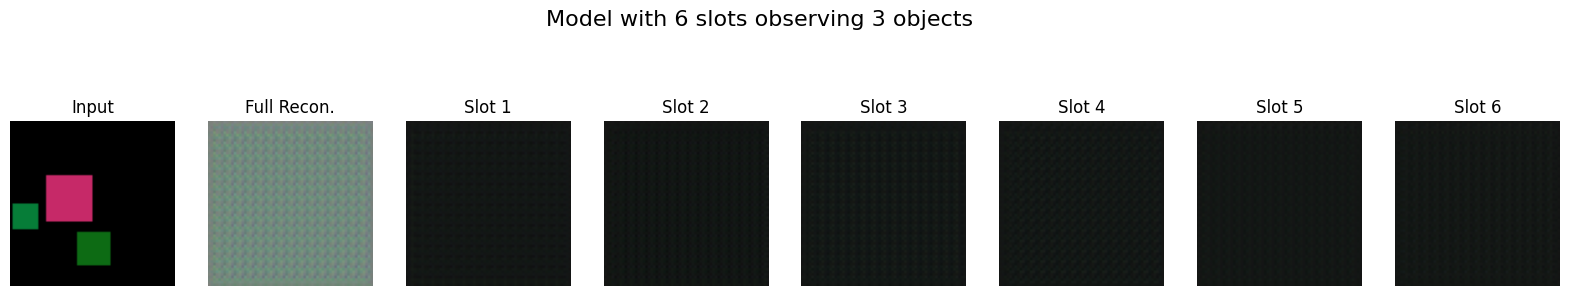

In [ ]:
# Cell 5: Demonstration Runner (Unchanged)
# =============================================================================
def run_slot_demo():
    print("="*80)
    print(" DEMO: Slot Attention for Dynamic Object Discovery (Final Corrected Version)")
    print("="*80)

    IMG_SHAPE, NUM_SLOTS, SLOT_DIM = (64, 64, 3), 6, 64

    model = build_slot_attention_autoencoder(IMG_SHAPE, num_slots=NUM_SLOTS, slot_dim=SLOT_DIM)
    print("Model built successfully.")

    def create_sample(img_size, num_objects):
        img = np.zeros((img_size, img_size, 3), dtype=np.float32)
        for _ in range(num_objects):
            size = np.random.randint(10, 20)
            x, y = np.random.randint(0, img_size - size), np.random.randint(0, img_size - size)
            color = np.random.rand(3)
            img[y:y+size, x:x+size] = color
        return img

    print("\n--- Scenario 1: 3 Objects ---")
    input_image_1 = create_sample(IMG_SHAPE[0], 3)
    input_tensor_1 = tf.expand_dims(input_image_1, axis=0)
    reconstruction, reconstructions_per_slot, masks, slots = model(input_tensor_1)

    fig, axs = plt.subplots(1, NUM_SLOTS + 2, figsize=(20, 4))
    fig.suptitle(f"Model with {NUM_SLOTS} slots observing 3 objects", fontsize=16)
    axs[0].imshow(input_image_1); axs[0].set_title("Input"); axs[0].axis('off')
    axs[1].imshow(reconstruction[0]); axs[1].set_title("Full Recon."); axs[1].axis('off')
    for i in range(NUM_SLOTS):
        slot_img, slot_mask = reconstructions_per_slot[0, i, :, :, :], masks[0, i, :, :, :]
        axs[i+2].imshow(slot_img * slot_mask); axs[i+2].set_title(f"Slot {i+1}"); axs[i+2].axis('off')
    plt.show()

# Run the final, correct demo
run_slot_demo()

In [ ]:
# =============================================================================
#
#   Complete, Trainable Slot Attention Model (Final, Robust Class-Based Version)
#
#   This version refactors the entire architecture into a single, clean,
#   and robust Keras Model class. This approach avoids all symbolic tensor
#   errors and represents the modern standard for building complex models.
#
# =============================================================================

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import time

# --- [Cell 1] The Complete Slot Attention Model Class ---
class SlotAttentionModel(models.Model):
    """A complete, end-to-end Slot Attention model as a single Keras class."""
    def __init__(self, img_shape, num_slots, slot_dim, num_iterations, **kwargs):
        super(SlotAttentionModel, self).__init__(**kwargs)
        self.img_shape = img_shape
        self.num_slots = num_slots
        self.slot_dim = slot_dim
        self.num_iterations = num_iterations
        self.encoder_cnn = self.build_encoder()
        self.slot_attention = SlotAttention(self.num_iterations, self.num_slots, self.slot_dim)
        # The resolution for the decoder is determined by the encoder's output
        self.decoder_resolution = self.encoder_cnn.output_shape[1:3]
        self.decoder_cnn = self.build_decoder()
        self.decoder_pos_grid = self.create_position_grid(self.decoder_resolution)

    def build_encoder(self):
        return models.Sequential([
            layers.InputLayer(input_shape=self.img_shape),
            layers.Conv2D(64, 5, strides=2, padding='same', activation='relu'),
            layers.Conv2D(64, 5, strides=2, padding='same', activation='relu'),
            layers.Conv2D(self.slot_dim, 5, padding='same', activation='relu')
        ], name="encoder")

    def create_position_grid(self, resolution):
        x_coords = tf.linspace(-1.0, 1.0, resolution[1])
        y_coords = tf.linspace(-1.0, 1.0, resolution[0])
        xx, yy = tf.meshgrid(x_coords, y_coords)
        grid = tf.stack([yy, xx], axis=-1)
        return tf.expand_dims(grid, axis=0)

    def build_decoder(self):
        # The input shape will be `(H, W, slot_dim + 2)`
        return models.Sequential([
            layers.Conv2DTranspose(64, 5, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(64, 5, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(self.img_shape[-1] + 1, 3, padding='same', activation=None) # Output 4 channels (RGBA)
        ], name="decoder")

    def call(self, inputs, training=False):
        features = self.encoder_cnn(inputs)
        slots = self.slot_attention(features, training=training)
        B, num_slots, slot_dim = tf.unstack(tf.shape(slots))
        slots_reshaped = tf.reshape(slots, (B * num_slots, 1, 1, slot_dim))
        slots_broadcast = tf.tile(slots_reshaped, [1, self.decoder_resolution[0], self.decoder_resolution[1], 1])
        pos_grid = tf.tile(self.decoder_pos_grid, [B * num_slots, 1, 1, 1])
        x = tf.concat([slots_broadcast, pos_grid], axis=-1)
        decoded_slots = self.decoder_cnn(x)
        decoded_slots = tf.reshape(decoded_slots, (B, num_slots, self.img_shape[0], self.img_shape[1], self.img_shape[2] + 1))
        reconstructions_per_slot = tf.nn.sigmoid(decoded_slots[..., :3])
        masks = tf.nn.softmax(decoded_slots[..., 3:], axis=1)
        reconstruction = tf.reduce_sum(reconstructions_per_slot * masks, axis=1)
        return reconstruction, reconstructions_per_slot, masks

# --- [Cell 2] The SlotAttention Layer (Self-Contained) ---
class SlotAttention(layers.Layer):
    """The Slot Attention mechanism. This remains a self-contained custom layer."""
    def __init__(self, num_iterations, num_slots, slot_dim, mlp_hidden_dim=128, epsilon=1e-8, **kwargs):
        super(SlotAttention, self).__init__(**kwargs)
        self.num_iterations, self.num_slots, self.slot_dim = num_iterations, num_slots, slot_dim
        self.mlp_hidden_dim, self.epsilon = mlp_hidden_dim, epsilon
    def build(self, input_shape):
        self.features_dim = input_shape[-1]
        self.slots_mu, self.slots_log_sigma = (self.add_weight(shape=(1, 1, self.slot_dim), initializer='glorot_uniform', name=n) for n in ['slots_mu', 'slots_log_sigma'])
        self.to_q, self.to_k, self.to_v = (layers.Dense(self.slot_dim, use_bias=False, name=n) for n in ['to_q', 'to_k', 'to_v'])
        self.gru = layers.GRUCell(self.slot_dim)
        self.mlp = models.Sequential([layers.Dense(self.mlp_hidden_dim, activation='relu'), layers.Dense(self.slot_dim)], name='slot_mlp')
        self.norm_inputs, self.norm_slots, self.norm_mlp = (layers.LayerNormalization() for _ in range(3))
    def call(self, inputs, training=False):
        B, H, W, _ = tf.unstack(tf.shape(inputs))
        features = self.norm_inputs(tf.reshape(inputs, (B, H * W, self.features_dim)))
        slots_init = tf.random.normal((B, self.num_slots, self.slot_dim))
        slots = self.slots_mu + tf.exp(self.slots_log_sigma) * slots_init
        k, v = self.to_k(features), self.to_v(features)
        for _ in range(self.num_iterations):
            slots_prev = slots
            slots = self.norm_slots(slots)
            q = self.to_q(slots) * (self.slot_dim ** -0.5)
            attn = tf.nn.softmax(tf.einsum('bsd,bpd->bsp', q, k), axis=1)
            attn = (attn + self.epsilon) / tf.reduce_sum(attn, axis=-1, keepdims=True)
            updates = tf.einsum('bsp,bpd->bsd', attn, v)
            slots_reshaped, _ = self.gru(tf.reshape(updates, (B * self.num_slots, self.slot_dim)), [tf.reshape(slots_prev, (B * self.num_slots, self.slot_dim))])
            slots = tf.reshape(slots_reshaped, (B, self.num_slots, self.slot_dim))
            slots += self.mlp(self.norm_mlp(slots))
        return slots

# --- [Cell 3] Data, Visualization, and Training ---
def create_sample(img_size=64, min_objects=2, max_objects=5):
    img = np.zeros((img_size, img_size, 3), dtype=np.float32)
    for _ in range(np.random.randint(min_objects, max_objects + 1)):
        size = np.random.randint(10, 20)
        x, y = np.random.randint(0, img_size - size), np.random.randint(0, img_size - size)
        img[y:y+size, x:x+size] = np.random.rand(3)
    return img

def visualize_reconstructions(model, num_slots):
    sample_image = create_sample(img_size=model.img_shape[0])
    reconstruction, recons_per_slot, masks = model(tf.expand_dims(sample_image, axis=0))
    fig, axs = plt.subplots(1, num_slots + 2, figsize=(20, 4))
    axs[0].imshow(sample_image); axs[0].set_title("Input"); axs[0].axis('off')
    axs[1].imshow(reconstruction[0]); axs[1].set_title("Full Recon."); axs[1].axis('off')
    for i in range(num_slots):
        axs[i+2].imshow(recons_per_slot[0, i] * masks[0, i]); axs[i+2].set_title(f"Slot {i+1}"); axs[i+2].axis('off')
    plt.show()

def main():
    # Hyperparameters
    IMG_SHAPE, NUM_SLOTS, SLOT_DIM = (64, 64, 3), 6, 64
    BATCH_SIZE, LEARNING_RATE, NUM_EPOCHS, STEPS_PER_EPOCH = 32, 0.0004, 20, 100

    # Build Model, Optimizer, and Loss
    model = SlotAttentionModel(IMG_SHAPE, NUM_SLOTS, SLOT_DIM, 3)
    optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
    loss_fn = tf.keras.losses.MeanSquaredError()

    # Data Pipeline
    # **** THE FIX IS HERE ****
    # We use a lambda function to correctly pass arguments to the generator.
    train_dataset = tf.data.Dataset.from_generator(
        lambda: (create_sample(img_size=IMG_SHAPE[0]) for _ in range(STEPS_PER_EPOCH * BATCH_SIZE)),
        output_signature=tf.TensorSpec(shape=IMG_SHAPE, dtype=tf.float32)
    ).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    @tf.function
    def train_step(images):
        with tf.GradientTape() as tape:
            reconstruction, _, _ = model(images, training=True)
            loss = loss_fn(images, reconstruction)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    print("="*80 + "\nSTARTING TRAINING\n" + "="*80)
    for epoch in range(NUM_EPOCHS):
        start_time, total_loss = time.time(), 0.0
        for step, images in enumerate(train_dataset.take(STEPS_PER_EPOCH)):
            loss = train_step(images)
            total_loss += loss
            print(f"\rEpoch {epoch+1}/{NUM_EPOCHS}, Step {step+1}/{STEPS_PER_EPOCH}, Loss: {loss:.6f}", end="")

        avg_loss = total_loss / STEPS_PER_EPOCH
        print(f"\nEpoch {epoch+1} summary: Avg Loss: {avg_loss:.6f}, Time: {time.time() - start_time:.2f}s")
        visualize_reconstructions(model, NUM_SLOTS)
    print("\nTraining finished.")

if __name__ == '__main__':
    main()

STARTING TRAINING
Epoch 1/20, Step 31/100, Loss: 0.054285